# EX 1 Week 2:
##Supernovae and accelerated expansion

## Colab Dependencies

In [2]:
%pip install camb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for camb: filename=camb-1.5.0-py3-none-any.whl size=1064772 sha256=4a1c9140c1cb7bbe8489e7d9e379f8ffdf5ebdead476e4b5f83b309a79f32238
  Stored in directory: /root/.cache/pip/wheels/56/8e/da/c29f503739e0e2dcf9b93784cd7067004e33cd930449600c50
Successfully built camb


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Real Code

In [3]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import camb as camb
import random as random

In [4]:
pars = camb.CAMBparams()
Omegam=0.3
pars.set_cosmology(H0=70.0, ombh2=0.05*(70.0/100)**2, omch2=(Omegam-0.05)*(70.0/100)**2);
# set_cosmology wants the PHYSICAL DENSITIES, that is the density parameter multiplied by (H0/100)^2
# camb prende H0 in km/s/Mpc, quindi non serve più dividere per c

# calculate background results:
results = camb.get_background(pars)

Importing data and covariance

In [8]:
data = np.loadtxt('/content/gdrive/MyDrive/Colab Notebooks/Cosmo2_Supernovae/data.txt', dtype=np.double) #taglia delle cifre, non trovo tipo con più precisione
#print(data)
redshifts=data[:,0]
magnitudes=data[:,1]
Sigma= np.loadtxt('/content/gdrive/MyDrive/Colab Notebooks/Cosmo2_Supernovae/covariance.txt', dtype=np.double)

Devo:
1. calcolare le distanze luminosità teoriche previste dal modello cosmologico senza radiazione nè curvatura
2. ricavare le distanze luminosità dai dati
3. l'unico parametro libero è $\Omega_m$ perchè $\Omega_{DE}=1-\Omega_m$ fissata.
4. fare un fit di likelihood per ricavare $\Omega_m$

Text(0, 0.5, '$\\mu(z)$')

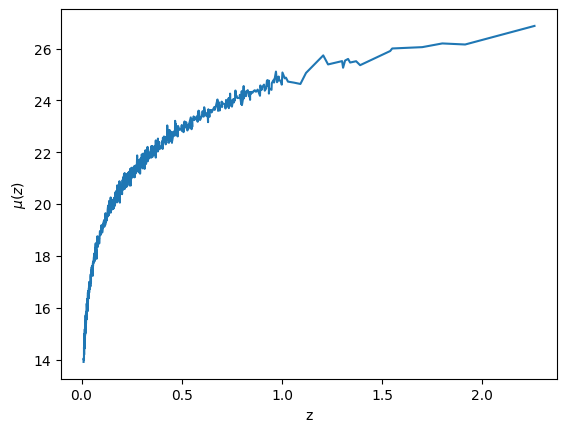

In [9]:
plt.plot(redshifts, magnitudes,label='$\mu(z)$')
plt.xlabel('z')
plt.ylabel('$\mu(z)$')

Calcolo le distanze attese dalla teoria con il codice dell'ex 1: valgono le seguenti
$\chi(z)=\int_0^z \frac{1}{H(z')}dz'$

$D_L(z)=\chi(z)(1+z)$

$\Omega_{DE}=1-\Omega_m$

In [10]:
# define parameters:

H0 = 70.0 / (299792)

# define function computing Hubble rate, cosmic time
def H(z, Omegam):
    return np.sqrt(H0**2*(Omegam*(1+z)**3+(1-Omegam)))
# define function to compute comoving radial distance:
def chi(z, Omegam):
    return integrate.quad(lambda x: 1./H(x, Omegam), 0, z)[0]
def D_L(z, Omegam):
    return chi(z,Omegam)*(1+z)
def mu_teo(z,Omegam):
    return 5*np.log10(D_L(z,Omegam))

Text(0, 0.5, '$H(z)$')

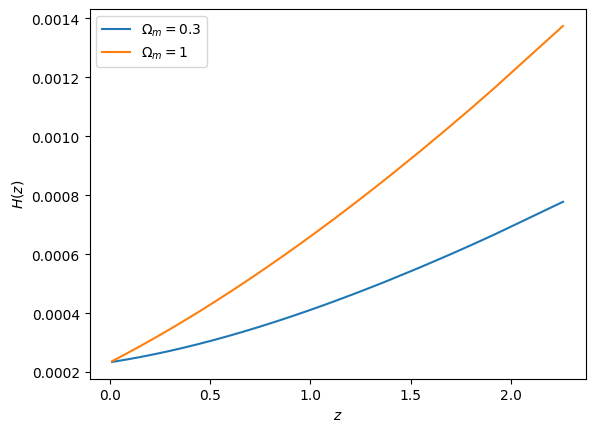

In [11]:
plt.plot(redshifts, [H(z,0.3) for z in redshifts], label='$\Omega_m=0.3$')
plt.plot(redshifts, [H(z,1) for z in redshifts], label='$\Omega_m=1$')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')

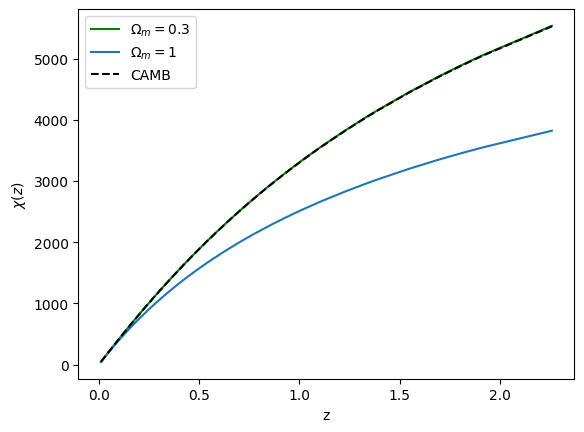

In [12]:
plt.plot(redshifts, [chi(z,0.3) for z in redshifts], label='$ \Omega_m=0.3$', color='green')
plt.plot(redshifts, [chi(z,1.) for z in redshifts], label='$ \Omega_m=1$')

chi_true = results.comoving_radial_distance(redshifts)

plt.plot(redshifts, chi_true,linestyle='--', label='CAMB', color='black')
plt.xlabel('z')
plt.ylabel('$\chi(z)$')
plt.legend()


Come mi aspetto se ho meno materia e più costante cosmologica le distanze proprie sono più elevate. Plotto le magnitudini misurate e quelle previste dal modello con $\Omega_m=0.3$

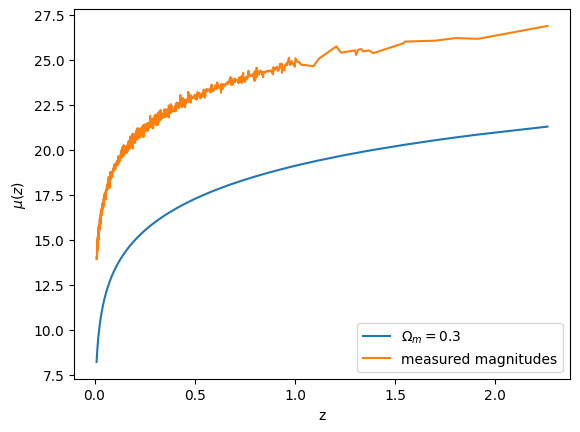

In [13]:
plt.plot(redshifts, [mu_teo(z, 0.3) for z in redshifts], label='$ \Omega_m=0.3$')
#plt.plot(redshifts, [mu_teo(z, 1) for z in redshifts], label='$ \Omega_m=1$')
plt.plot(redshifts, magnitudes, label='measured magnitudes')
plt.xlabel('z')
plt.ylabel('$\mu (z)$')
plt.legend()

Definisco la likelihood

In [14]:
def logL(data,theory,inverse):
    v=data-theory
    one=np.ones_like(v)
    return -0.5*v.dot(inverse).dot(v)+0.5*(one.dot(inverse).dot(v))**2/(one.dot(inverse).dot(one))

def L(data,theory, inverse):
    return np.exp(logL(data,theory,inverse))

Text(0, 0.5, 'logL')

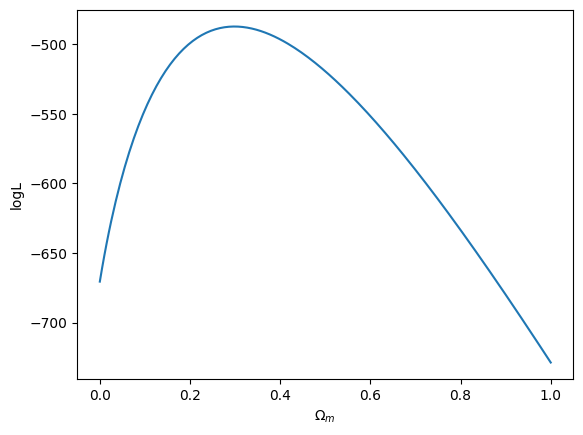

In [15]:
inverse=np.linalg.inv(Sigma)  ##computing inverse covariance
omegas=np.linspace(0,1,200)
L=[]
for o in omegas:
    theory=[mu_teo(z,o) for z in redshifts]
    L.append(logL(magnitudes, theory, inverse))

plt.plot(omegas, L)
plt.xlabel('$\Omega_m$')
plt.ylabel('logL')


In [16]:
OmegaBest=omegas[L.index(max(L))]
print ('L is max for $\Omega_m$=', OmegaBest)

L is max for $\Omega_m$= 0.2964824120603015


Text(0, 0.5, 'L')

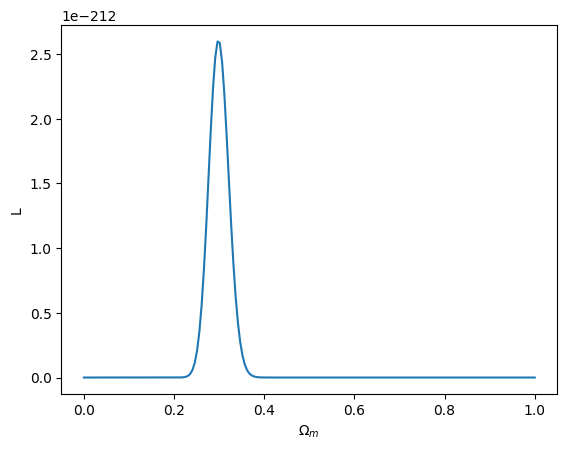

In [17]:
L=np.exp(L)

plt.plot(omegas, L)
plt.xlabel('$\Omega_m$')
plt.ylabel('L')

Calcolo media e varianza della likelihood

In [18]:
N=np.trapz(L,omegas)         ##normalization factor
L=L/N                        ##normalized likelihood
#print(np.trapz(L,omegas))
I=np.array(omegas)
for i in range(0,len(omegas)):
    I[i]=omegas[i]*L[i]
mean=np.trapz(I,omegas)
print(mean)


0.29970000425968035


In [19]:
S=np.array(omegas)
for i in range(0,len(omegas)):
    S[i]=(omegas[i]-mean)**2*L[i]
RMS=np.trapz(S,omegas)
print(RMS)

0.00048174814060826445


In [20]:
print(mean-RMS,mean+RMS)

0.2992182561190721 0.3001817524002886
